In [3]:
import seaborn as sns
%matplotlib inline

In [4]:
from fastai.datasets import untar_data, URLs
from fastai.text import *

import torch
from tqdm import tqdm_notebook as tqdm

In [5]:
torch.cuda.current_device()

0

In [6]:
def pad_to_length(in_seq):
    N = 250
    return (in_seq + N * [PAD])[:N]
defaults.text_post_rules.append(pad_to_length)
        
    

In [7]:
from pathlib import Path

In [13]:
path = untar_data(URLs.IMDB_SAMPLE, dest=Path('/media/nas_mount/Karmanya'))

In [14]:
import pandas as pd

In [15]:
map_labels = {'negative': 0.0, 'positive': 1.0}

In [16]:
frame = pd.read_csv(path/'texts.csv')
frame['label'] = frame['label'].map(map_labels)
train_frame = frame[~frame['is_valid']]
valid_frame = frame[frame['is_valid']]
print(train_frame.shape, valid_frame.shape)

(800, 3) (200, 3)


In [17]:
dc = TextClasDataBunch.from_df(path, train_df=train_frame,
                               valid_df=valid_frame,
                               test_df=valid_frame,
                               max_vocab=16864, min_freq=1, bs=32)

In [18]:
dc.save('dc_export.pkl')

In [19]:
from pymagnitude import *
vectors = Magnitude('/media/nas_mount/Karmanya/magnitude_vectors/wiki-news-300d-1M-subword.magnitude')

In [20]:
len(dc.vocab.itos)

13320

In [21]:
len(dc.vocab.stoi)

15128

In [22]:
for ind, word in enumerate(dc.vocab.itos):
    if dc.vocab.stoi[word] != ind:
        print(word, dc.vocab.itos[ind])

In [23]:
weights = torch.from_numpy(vectors.query(dc.vocab.itos))

In [24]:
import torch.nn as nn

In [25]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, n_filters, filter_sizes, output_dim, weights, sentence_len, dropout):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=False,).cuda()
        self.conv_layers = [
            nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(filter_size, embedding_dim)),
                nn.ReLU()).cuda()
            for filter_size in filter_sizes
        ]
        self.pooling_layers = [nn.MaxPool1d(sentence_len - fs + 1).cuda() for fs in filter_sizes]
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim).cuda()
        self.dropout = nn.Dropout(dropout).cuda()
        
    def forward(self, text):
        #text = [batch size, sent len]
        embedded = self.embedding(text)
        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)
        #embedded = [batch size, 1, sent len, emb dim]
        feature_maps = [conv(embedded).squeeze(3) for conv in self.conv_layers]
        pooled_layers = [pool(feature_map).squeeze(2) for pool, feature_map in zip(self.pooling_layers, feature_maps)]
        
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat((pooled_layers), dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat).squeeze()

In [26]:
net = CNN(embedding_dim=300, 
          n_filters=3, filter_sizes=[3,4,5], output_dim=1,
          weights=weights, sentence_len=250, dropout=0.5)

In [27]:
net = net.cuda()

In [ ]:
batch = next(iter(dc.train_dl))

In [28]:
loss_func = nn.BCEWithLogitsLoss()

In [29]:
learner = Learner(dc, net, loss_func=loss_func, path=path)

In [30]:
learner.lr_find()

epoch,train_loss,valid_loss,time
0,0.715024,#na#,00:01
1,0.717189,#na#,00:00
2,0.713944,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


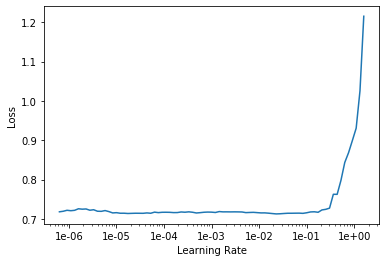

In [31]:
learner.recorder.plot()

In [36]:
learner.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.213316,0.568508,00:01
1,0.220929,0.561638,00:01
2,0.212930,0.556097,00:01
3,0.211896,0.553928,00:01
4,0.199745,0.553562,00:01


In [37]:
learner.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,time
0,0.198652,0.553620,00:01
1,0.198964,0.553922,00:01
2,0.190274,0.554182,00:01
3,0.184778,0.554597,00:01
4,0.176811,0.555175,00:01
5,0.173802,0.556011,00:01
6,0.171646,0.555025,00:01
7,0.163818,0.557003,00:01
8,0.158045,0.557341,00:01
9,0.159766,0.556535,00:01


In [38]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.135847,0.557688,00:01
1,0.138461,0.558557,00:01
2,0.137771,0.556172,00:01
3,0.138729,0.557211,00:01
4,0.143365,0.558092,00:01
5,0.133238,0.557527,00:01
6,0.129896,0.557985,00:01
7,0.131883,0.557783,00:01
8,0.132702,0.557923,00:01
9,0.123556,0.557903,00:01


In [ ]:
learner.save('classifier_learner')

In [ ]:
learner.get_preds()

In [ ]:
ls .fastai/data/imdb